**Task 1: Add values**

This module implements an algorithm to find a subset of an array with sum equal to a target number using Qiskit, with theoretical worst-case performance (roughly) quadratically better than a naive search (assuming optimal choice for number of iterations of Grover's operator, which can be done using quantum phase estimation but has not yet been implemented here).

The algorithm used here is inspired by Daskin 2017 [1] which also concerned subset-sums but had the aim to output the maximum subset sum less than a specified number, as opposed to outputting indices of elements which add up to a target which we are trying to do here. The algorithm implemented below has the following general structure:

**Input**: Vector *V* of *N*  nonnegative integers each *n* bits long, and a target value also *n* bits long.
1. The sum *T* of all elements in the vector is calculated, followed by *L* = ceiling(log(*T*)). All vector values are divided by  2^*L* so that all potential subset sums are now less than 1 (for compatability with inverse QFT later).
2. 2 quantum registers are created for the circuit: a sum register size *L* and a key register size *N*.
3. Hadamard gates are applied to each qubit in the key register. Representing each subset of *V* as a binary string (where 1 in the *j*th bit implies value *j* is included the subset), this step creates an equal superposition of all possible subset strings in the key register.
4. Unitary operator *U* is defined by applying *U*1(2 • pi • *vj*) to each key register qubit *j*, where *vj* is the value of the *j*th element of *V*.
5. Hadamard gates are applied to each qubit in the sum register. Then, for each qubit *j*, a controlled *U* is applied to the key register 2^*j* times with sum register qubit *j* as the control. This is analagous to a similar step in the standard phase estimation algorithm (here applying controlled *U* to a superposition of eigenstates instead of just one eigenstate) and the output of this step is an equal superposition of states of the form QFT(|sum(*x*)>)|*x*>, for all possible binary strings *x* of length *N*. Here |*x*> is the key register state, *x* is a binary string indicating which elements of *V* are in a subset as discussed in step 3, QFT(|sum(*x*)>) is the state of the sum register, and  sum(*x*) is the sum of all elements in the subset indicated by *x*, as a binary string.
6. An inverse QFT is applied to the sum register, giving an equal superposition of states |sum(*x*)>|*x*> for all subset strings *x*. Let the overall operation of the circuit up the this point = *A*
7. An oracle operator *O* is defined which applies a phase flip to any states where the sum register |sum(*x*)> = |*t*>, where *t* is a binary representation of the target value, using Qiskit's Diagonal class.
8. Qiskit's GroverOperator class is used to define a Grover iteration, taking *O* and *A* as input and constructing *G* = *A • S_0 •  A_dgr •  O*, where *A_dgr* is the inverse of *A*, and *S_0* applies a phase flip to the |0...0>|0...0> state.
9. *G* is applied *R* times to the output of step 6, and the key register is then measured to obtain the final subset string. If *R* is chosen optimally, then with high probability the measured subset string will indicate a subset of *V* with sum equal to the target. Optimal *R* should be on the order of 2^(*N*/2) / sqrt(*M*), where *M* is the number of subsets with sum equal to *t*. Optimal *R* can be estimated for a given input using a quantum counting algorithm, which has not been implemented here.

The time complexities for these steps are roughly:
1. *O*(*N*)
2. *O*(*N* + *n*)
3. *O*(*N*)
4. *O*(*N*)
5. *O*(*N*^2 • 2^2*n*)
6. *O*((*n* + log(*N*))^2)
7. *O*(*N* • 2^*n*)
8. *O*(*N*^2 • 2^2*n*) - *S_0* is implemented in *O*(*N*) operations through the use of *O*(*N*) ancilla qubits [2]
9. *O*(2^(*N*/2 + 2log*N*) • 2^2*n* • *M*^-1/2)



**References**

[1] A. Daskin, "A Quantum Approach to Subset-Sum and Similar Problems," 2017, doi: 10.48550

[2] M. Nielsen and I. Chuang, "Quantum Computation and Quantum Information: 10th Anniversary Edition," *Cambridge: Cambridge University Press*, 2010, doi:10.1017/CBO9780511976667

# Imports and setup

In [1]:
import numpy as np

from qiskit import Aer, transpile
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import Diagonal, GroverOperator
from qiskit.circuit.library.basis_change.qft import QFT
from qiskit.tools.visualization import plot_histogram

In [2]:
TAU = 2 * np.pi

# Algorithm implementation

In [3]:
def num_qubits(n_keys, total):
    """Calculate number of qubits needed in quantum regs for subset search"""
    n_value_qubits = int(np.ceil(np.log2(total)))
    n_total_qubits = n_keys + n_value_qubits
    return n_value_qubits, n_total_qubits

In [4]:
def exp_sums_circuit(values):
    """
    Unitary circuit that, applied to binary state, will give exponentiated sum
    of values in array positions where binary state bits equal 1
    """
    qc = QuantumCircuit(len(values))
    for i, val in enumerate(reversed(values)):
        qc.p(TAU * val, i)
    return qc

In [5]:
def initialize_circuit(n_value_qubits, 
                       n_keys, 
                       n_ancillas=0,
                       n_classical=0,
                       name=None):
    """Create new circuit with specified register sizes"""
    ns = [n_value_qubits, n_keys]
    if n_ancillas:
        ns.append(n_ancillas)
    regs = [QuantumRegister(n) for n in ns]
    if n_classical:
        regs.append(ClassicalRegister(n_classical))
    return QuantumCircuit(*regs, name=name), *regs

In [6]:
def sums_preparation_circuit(U, n_value_qubits, n_keys, name=None):
    """
    Circuit to create superposition of exponentiation of all possible sums of 
    elements in values array
    """
    sums_prep, sum_reg, key_reg = initialize_circuit(n_value_qubits, 
                                                     n_keys, 
                                                     name=name)
    sums_prep.h(sum_reg)
    sums_prep.h(key_reg)
    
    # Exponentially increate number of U applications with each rep
    repetitions = 1
    for sum_qubit in reversed(sum_reg):
        for _ in range(repetitions):
            sums_prep.append(U.control(), [sum_qubit] + key_reg[:])
        repetitions *= 2

    qft_dagger = QFT(n_value_qubits, do_swaps=False, inverse=True)
    sums_prep.append(qft_dagger, sum_reg)
    return sums_prep


In [7]:
def oracle_circuit(target, n_value_qubits, n_keys, name=None):
    """
    Circuit which applies phase flip to states with binary representation
    equal to target
    """
    target_array = np.zeros(2 ** n_value_qubits)
    target_array[target] = 1
    diag = Diagonal((-1) ** target_array) # target value phase flip
    
    oracle, sum_reg, key_reg = initialize_circuit(n_value_qubits, 
                                                  n_keys, 
                                                  name=name)
    oracle.append(diag, sum_reg[:])
    return oracle

In [8]:
def grover_circuit(oracle, sums_prep, n_value_qubits, name=None):
    """
    Grover iteration circuit
    """
    return GroverOperator(oracle,
                          state_preparation=sums_prep,
                          insert_barriers=True,
                          mcx_mode='v-chain',
                          name=name)

In [9]:
def estimate_iterations(values, target):
    """
    Estimated optimal number of iterations for subset sum Grover search
    """
    # TODO: Implement this statisticallly e.g. using Irwin-Hall distribution
    # or better yet with a Quantum Counting algorithm
    raise NotImplementedError

In [10]:
def subset_sum_circuit(values, target, iterations=None):
    """
    Circuit which finds subsets of values array with sum equal to target with
    high probability, in O(2^(n/2)) time where n=number of elements in target
    array, assuming fixed number of bits per value and optimal number of
    iterations
    """
    n_keys = len(values)
    total = sum(values)
    n_value_qubits, n_total_qubits = num_qubits(n_keys, total)
    
    values_normed = values / (2 ** n_value_qubits)
    U = exp_sums_circuit(values_normed)
    sums_prep = sums_preparation_circuit(U, n_value_qubits, n_keys, name='SP')
    oracle = oracle_circuit(target, n_value_qubits, n_keys, name='O')
    grover_op = grover_circuit(oracle, sums_prep, n_value_qubits, name='Q') 
    n_ancillas = len(grover_op.ancillas) # order n_keys
    
    # TODO: Implement estimate_iterations
    if iterations is None:
        iterations = estimate_iterations(values, target)
    
    qc, sum_reg, key_reg, _, _ = initialize_circuit(n_value_qubits, 
                                                    n_keys,
                                                    n_ancillas=n_ancillas,
                                                    n_classical=n_keys,
                                                    name='subset_sum')
    qc.append(sums_prep, sum_reg[:] + key_reg[:])
    for _ in range(iterations):
        qc.append(grover_op, qc.qubits)
    qc.measure(key_reg, qc.clbits)
    return qc

# Tests

In [11]:
simulator = Aer.get_backend('qasm_simulator')

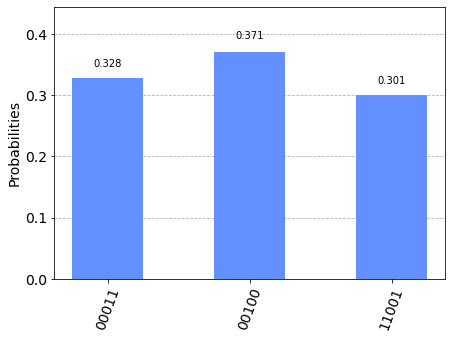

In [13]:
# Test input
vs = np.array([1, 3, 6, 4, 2])
targ = 6
iterations = 2

qc = subset_sum_circuit(vs, targ, iterations=iterations)
qc = transpile(qc, simulator)
result = simulator.run(qc).result()
counts = result.get_counts(qc)
plot_histogram(counts)

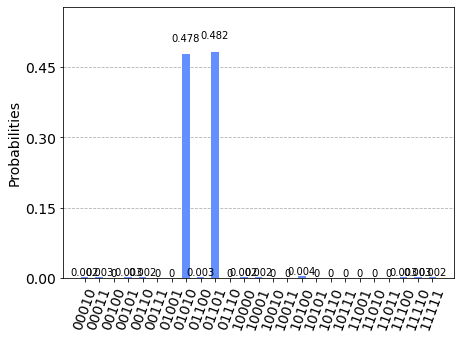

In [14]:
# Challenge input
vs = np.array([5, 7, 8, 9, 1])
targ = 16
iterations = 3

qc = subset_sum_circuit(vs, targ, iterations=iterations)
qc = transpile(qc, simulator)
result = simulator.run(qc).result()
counts = result.get_counts(qc)
plot_histogram(counts)

Success!(ish)

The optimal number of Grover iterations for the above tasks (2 and 3 iterations, respectively) were essentially found through trial and error.

Future work:
- Implement a quantum counting algorithm to estimate the optimal *R* for a given input.
- Make the current implementation more time/memory efficient: oracle operator is quite simple but diffusion operator is much longer and requires ancilla qubits.
- Investigate depth of circuit for different input vector sizes empirically to see if my rough complexity calculations are accurate.